<a href="https://colab.research.google.com/github/fuserkuba/OrderTaking/blob/master/training/TakeOrderTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

LOADING DATA

In [2]:
import pandas as pd
import numpy as np
import requests


filename = "https://raw.githubusercontent.com/fuserkuba/OrderTaking/master/training/orders.csv"

df = pd.read_csv(filename, na_values=[""])

print("{} rows loaded! \n".format(df.shape[0]))

df.info()

146987 rows loaded! 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146987 entries, 0 to 146986
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   order_id           146987 non-null  int64  
 1   store_id           146987 non-null  int64  
 2   to_user_distance   146987 non-null  float64
 3   to_user_elevation  146987 non-null  float64
 4   total_earning      146987 non-null  int64  
 5   created_at         146987 non-null  object 
 6   taken              146987 non-null  int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 7.9+ MB


# EXPLORATORY DATA ANALYSIS

In [3]:
display(df.head())

display(df.describe())

,order_id,store_id,to_user_distance,to_user_elevation,total_earning,created_at,taken
0,14364873,30000009,2.478101,-72.719360,4200,2017-09-07T20:02:17Z,0
1,14370123,30000058,0.451711,37.754761,4200,2017-09-07T20:13:16Z,0
2,14368534,900003684,2.026072,207.191162,4000,2017-09-07T20:07:23Z,0
3,14370258,900014452,2.671432,1.722656,4400,2017-09-07T20:15:19Z,1
4,14369923,900014085,0.965496,117.429199,3450,2017-09-07T20:12:14Z,1


,order_id,store_id,to_user_distance,to_user_elevation,total_earning,taken
count,1.469870e+05,1.469870e+05,146987.000000,146987.000000,146987.000000,146987.000000
mean,1.507718e+07,7.580708e+08,1.501015,26.899130,5358.641594,0.921218
std,4.750119e+05,3.214280e+08,0.845776,84.907724,1779.800955,0.269400
min,1.421073e+07,3.000000e+07,0.000000,-598.296875,0.000000,0.000000
25%,1.466969e+07,9.000045e+08,0.836511,-18.348755,4200.000000,1.000000
50%,1.509241e+07,9.000077e+08,1.390230,11.145264,5200.000000,1.000000
75%,1.547355e+07,9.000127e+08,2.029955,61.024353,6300.000000,1.000000
max,1.590252e+07,9.000173e+08,9.360177,1009.380005,108200.000000,1.000000


In [4]:
display(df.taken.value_counts().sort_index())
print("{} % of orders were taken".format(df.taken.mean()*100))

0     11580
1    135407
Name: taken, dtype: int64

92.12175226380565 % of orders were taken


,order_id,store_id,to_user_distance,to_user_elevation,total_earning,created_at,taken
102163,14323700,900010714,1.388912,48.826538,0,2017-09-07T12:02:05Z,1


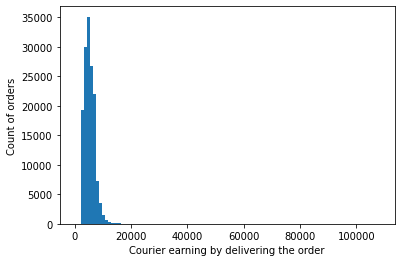

,order_id,store_id,to_user_distance,to_user_elevation,total_earning,created_at,taken
16847,14362872,900012381,0.0,0.0,5000,2017-09-07T19:48:10Z,0


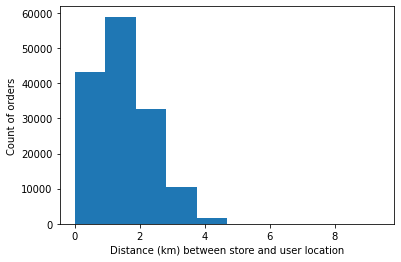

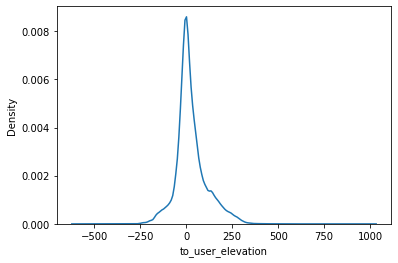

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# No earning
display(df[df.total_earning == 0].head())

plt.hist(df.total_earning, bins=100)
plt.xlabel('Courier earning by delivering the order')
plt.ylabel('Count of orders')
plt.show()


# No distance
display(df[df.to_user_distance == 0].head())
plt.hist(df.to_user_distance, bins=10)
plt.xlabel('Distance (km) between store and user location')
plt.ylabel('Count of orders')
plt.show()

#plt.hist(df.to_user_elevation, bins=100)
#plt.xlabel('Difference in meters between the store and user altitude')
#plt.ylabel('Count of orders')
#plt.show()
sns.kdeplot(df.to_user_elevation)



## CLEANING DATA

In [6]:
df.total_earning.replace(0,np.nan, inplace=True)
df.to_user_distance.replace(0,np.nan, inplace=True)

display(df.describe())

,order_id,store_id,to_user_distance,to_user_elevation,total_earning,taken
count,1.469870e+05,1.469870e+05,146986.000000,146987.000000,146986.000000,146987.000000
mean,1.507718e+07,7.580708e+08,1.501026,26.899130,5358.678051,0.921218
std,4.750119e+05,3.214280e+08,0.845770,84.907724,1779.752125,0.269400
min,1.421073e+07,3.000000e+07,0.002456,-598.296875,200.000000,0.000000
25%,1.466969e+07,9.000045e+08,0.836530,-18.348755,4200.000000,1.000000
50%,1.509241e+07,9.000077e+08,1.390234,11.145264,5200.000000,1.000000
75%,1.547355e+07,9.000127e+08,2.029961,61.024353,6300.000000,1.000000
max,1.590252e+07,9.000173e+08,9.360177,1009.380005,108200.000000,1.000000


# TRAINING

In [37]:
features = ['to_user_distance','to_user_elevation','total_earning']
target = ['taken']

X = df[features].values
y = df[target].values.reshape(-1,1)

display(X[:5],X.shape)
display(y[:5],y.shape)

array([[ 2.47810068e+00, -7.27193604e+01,  4.20000000e+03],
       [ 4.51710600e-01,  3.77547607e+01,  4.20000000e+03],
       [ 2.02607186e+00,  2.07191162e+02,  4.00000000e+03],
       [ 2.67143172e+00,  1.72265625e+00,  4.40000000e+03],
       [ 9.65496042e-01,  1.17429199e+02,  3.45000000e+03]])

(146987, 3)

array([[0],
       [0],
       [0],
       [1],
       [1]])

(146987, 1)

## PREPARE TRAIN AND TEST DATA

In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21, stratify=y)

print("Training set X: {}  y: {}".format(X_train.shape,y_train.shape))
print("Test set X: {}  y: {}".format(X_test.shape,y_test.shape))

Training set X: (102890, 3)  y: (102890, 1)
Test set X: (44097, 3)  y: (44097, 1)


In [54]:
from sklearn.preprocessing import StandardScaler
#
from sklearn.pipeline import Pipeline
#
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier(n_neighbors=3)

steps = [('scaler', StandardScaler()),
         ('clf', classifier)]

pipeline = Pipeline(steps)

parameters = {'clf__n_neighbors': (3,5,10)}


## TRAINING WITH CROSS VALIDATION

In [55]:
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from time import time

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)
t0 = time()
grid_search.fit(X_train, y_train)
print("Done in %0.3fs" % (time() - t0))
print()
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
  print("\t%s: %r" % (param_name, best_parameters[param_name]))

model=grid_search.best_estimator_

print("\nBEST MODEL :")
display(model)

Performing grid search...
pipeline: ['scaler', 'clf']
parameters:
{'clf__n_neighbors': (3, 5, 10)}
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   11.4s finished
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


Done in 11.677s

Best score: 0.919
Best parameters set:
	clf__n_neighbors: 10

BEST MODEL :


Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=10, p=2,
                                      weights='uniform'))],
         verbose=False)

# TEST MODEL

In [60]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score


y_pred = model.predict(X_test)
print("confusion matrix:")
display(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Accuracy: {}".format(accuracy_score(y_test, y_pred)))

confusion matrix:


array([[   47,  3427],
       [  152, 40471]])

              precision    recall  f1-score   support

           0       0.24      0.01      0.03      3474
           1       0.92      1.00      0.96     40623

    accuracy                           0.92     44097
   macro avg       0.58      0.50      0.49     44097
weighted avg       0.87      0.92      0.88     44097

Accuracy: 0.9188380161915777


# SAVE MODEL

In [62]:
import joblib

filename='model.joblib'

joblib.dump(model, filename)

['model.joblib']